In [2]:
from luwiji.rnn import illustration

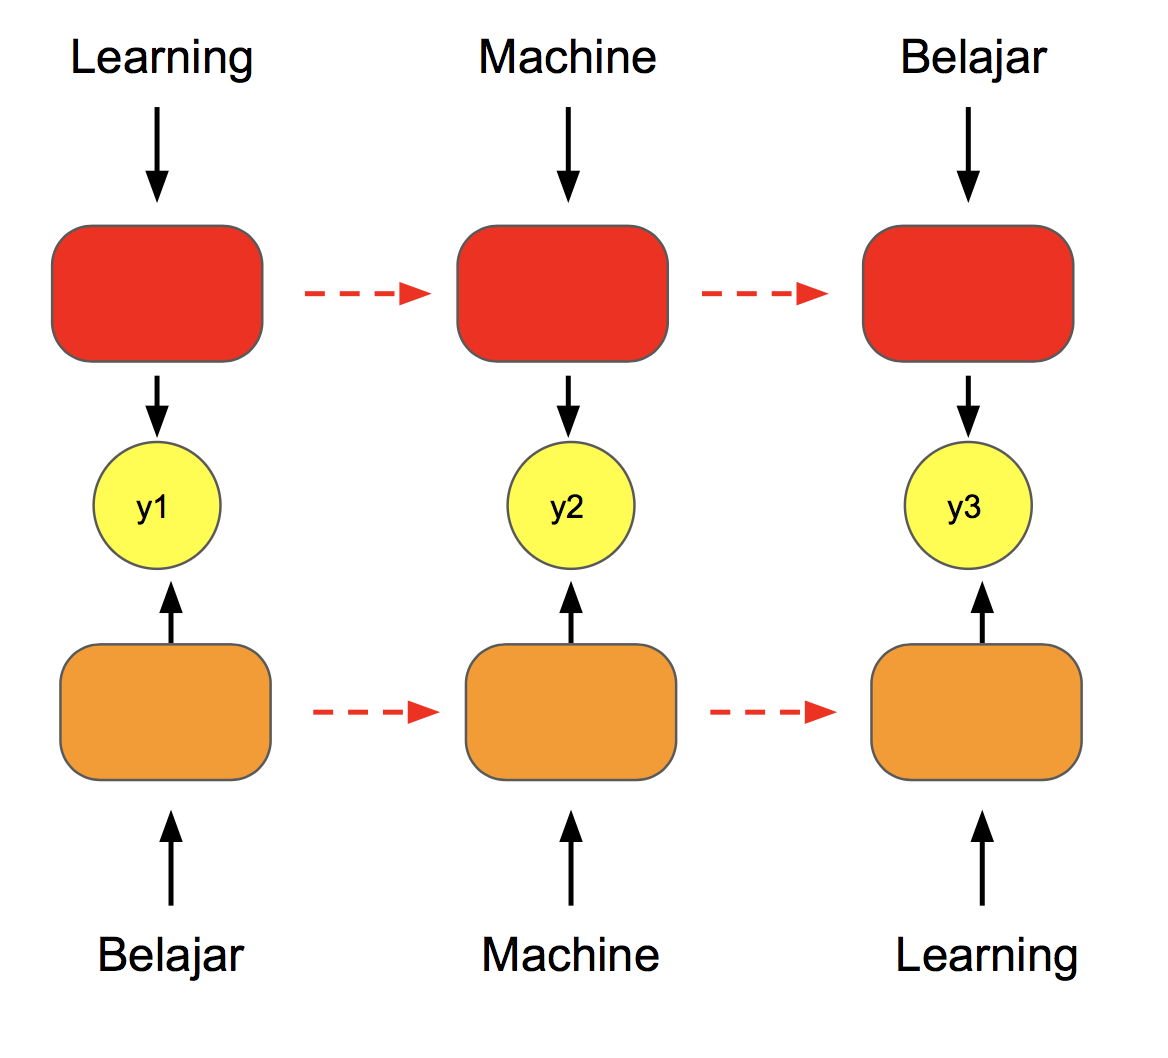

In [3]:
illustration.blstm

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split 

In [5]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Import data

In [6]:
df = pd.read_csv("data/daily_min_temp.csv", index_col="Date", parse_dates=["Date"])
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


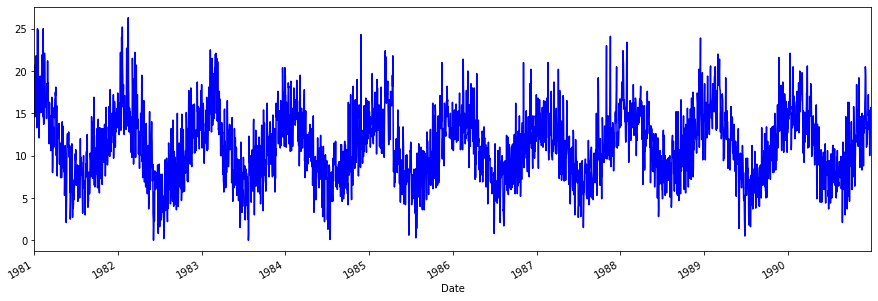

In [7]:
df.Temp.plot(figsize=(15,5), color = "b")

# Dataset Spliting

In [8]:
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle = False)
ts_train.shape, ts_test.shape

((2920, 1), (730, 1))

# Dataset dan dataloader

In [9]:
from jcopdl.utils.dataloader import TimeSeriesDataset
from torch.utils.data import DataLoader 

In [10]:
seq_len = 14
bs = 32

train_set = TimeSeriesDataset(ts_train,"Temp", seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test,"Temp",seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (208, 14, 1)
Note: last 7 data excluded

(N, S, F): (52, 14, 1)
Note: last 1 data excluded



# Arsitektur dan config

In [13]:
class BILSTM(nn.Module):
    def __init__(self, input_size,output_size, hidden_size, num_layers, dropout):
        super().__init__()
        
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, dropout = dropout, batch_first =True, bidirectional=True)
        self.fc = nn.Linear(2*hidden_size, output_size)
        
    def forward(self, x, hidden):
        x , hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden
        

In [14]:
config = set_config({
    "input_size": train_set.n_feature,
    "seq_len": train_set.n_seq,
    "output_size":1,
    "hidden_size": 64,
    "num_layers": 2,
    "dropout": 0
})

# Training Preparation

In [36]:
model = BILSTM(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduce="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
callback = Callback(model, config, outdir="model/Bilstm")

# Training

In [37]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost



Epoch     1
Train_cost  = 139.0758 | Test_cost  = 146.1521 | 




Epoch     2
Train_cost  = 136.6029 | Test_cost  = 143.5465 | 




Epoch     3
Train_cost  = 134.0864 | Test_cost  = 140.8465 | 




Epoch     4
Train_cost  = 131.4441 | Test_cost  = 137.9563 | 




Epoch     5
Train_cost  = 128.5797 | Test_cost  = 134.7701 | 




Epoch     6
Train_cost  = 125.3897 | Test_cost  = 131.1793 | 




Epoch     7
Train_cost  = 121.7708 | Test_cost  = 127.0848 | 




Epoch     8
Train_cost  = 117.6355 | Test_cost  = 122.4184 | 




Epoch     9
Train_cost  = 112.9360 | Test_cost  = 117.1720 | 




Epoch    10
Train_cost  = 107.6930 | Test_cost  = 111.4223 | 




Epoch    11
Train_cost  = 102.0141 | Test_cost  = 105.3337 | 




Epoch    12
Train_cost  = 96.0843 | Test_cost  = 99.1242 | 




Epoch    13
Train_cost  = 90.1191 | Test_cost  = 92.9994 | 




Epoch    14
Train_cost  = 84.2997 | Test_cost  = 87.0991 | 




Epoch    15
Train_cost  = 78.7361 | Test_cost  = 81.4915 | 




Epoch    16
Train_cost  = 73.4785 | Test_cost  = 76.2077 | 




Epoch    17
Train_cost  = 68.5545 | Test_cost  = 71.2791 | 




Epoch    18
Train_cost  = 63.9942 | Test_cost  = 66.7372 | 




Epoch    19
Train_cost  = 59.8176 | Test_cost  = 62.5872 | 




Epoch    20
Train_cost  = 56.0160 | Test_cost  = 58.8046 | 


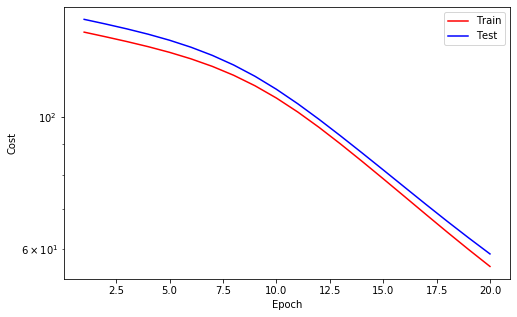



Epoch    21
Train_cost  = 52.5614 | Test_cost  = 55.3601 | 




Epoch    22
Train_cost  = 49.4276 | Test_cost  = 52.2324 | 




Epoch    23
Train_cost  = 46.5954 | Test_cost  = 49.4039 | 




Epoch    24
Train_cost  = 44.0453 | Test_cost  = 46.8514 | 




Epoch    25
Train_cost  = 41.7515 | Test_cost  = 44.5455 | 




Epoch    26
Train_cost  = 39.6847 | Test_cost  = 42.4572 | 




Epoch    27
Train_cost  = 37.8178 | Test_cost  = 40.5616 | 




Epoch    28
Train_cost  = 36.1281 | Test_cost  = 38.8375 | 




Epoch    29
Train_cost  = 34.5957 | Test_cost  = 37.2661 | 




Epoch    30
Train_cost  = 33.2030 | Test_cost  = 35.8312 | 




Epoch    31
Train_cost  = 31.9353 | Test_cost  = 34.5191 | 




Epoch    32
Train_cost  = 30.7799 | Test_cost  = 33.3182 | 




Epoch    33
Train_cost  = 29.7258 | Test_cost  = 32.2181 | 




Epoch    34
Train_cost  = 28.7633 | Test_cost  = 31.2095 | 




Epoch    35
Train_cost  = 27.8843 | Test_cost  = 30.2859 | 




Epoch    36
Train_cost  = 27.0829 | Test_cost  = 29.4415 | 




Epoch    37
Train_cost  = 26.3533 | Test_cost  = 28.6695 | 




Epoch    38
Train_cost  = 25.6881 | Test_cost  = 27.9615 | 




Epoch    39
Train_cost  = 25.0793 | Test_cost  = 27.3092 | 




Epoch    40
Train_cost  = 24.5197 | Test_cost  = 26.7059 | 


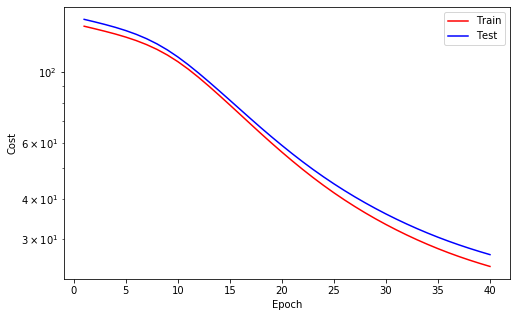



Epoch    41
Train_cost  = 24.0034 | Test_cost  = 26.1458 | 




Epoch    42
Train_cost  = 23.5254 | Test_cost  = 25.6244 | 




Epoch    43
Train_cost  = 23.0815 | Test_cost  = 25.1376 | 




Epoch    44
Train_cost  = 22.6685 | Test_cost  = 24.6822 | 




Epoch    45
Train_cost  = 22.2832 | Test_cost  = 24.2551 | 




Epoch    46
Train_cost  = 21.9232 | Test_cost  = 23.8538 | 




Epoch    47
Train_cost  = 21.5860 | Test_cost  = 23.4760 | 




Epoch    48
Train_cost  = 21.2695 | Test_cost  = 23.1193 | 




Epoch    49
Train_cost  = 20.9718 | Test_cost  = 22.7819 | 




Epoch    50
Train_cost  = 20.6912 | Test_cost  = 22.4620 | 




Epoch    51
Train_cost  = 20.4261 | Test_cost  = 22.1586 | 




Epoch    52
Train_cost  = 20.1760 | Test_cost  = 21.8714 | 




Epoch    53
Train_cost  = 19.9405 | Test_cost  = 21.6004 | 




Epoch    54
Train_cost  = 19.7193 | Test_cost  = 21.3452 | 




Epoch    55
Train_cost  = 19.5118 | Test_cost  = 21.1048 | 




Epoch    56
Train_cost  = 19.3169 | Test_cost  = 20.8783 | 




Epoch    57
Train_cost  = 19.1337 | Test_cost  = 20.6645 | 




Epoch    58
Train_cost  = 18.9611 | Test_cost  = 20.4624 | 




Epoch    59
Train_cost  = 18.7982 | Test_cost  = 20.2709 | 




Epoch    60
Train_cost  = 18.6441 | Test_cost  = 20.0892 | 


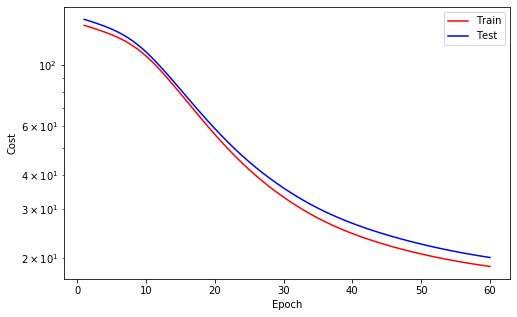



Epoch    61
Train_cost  = 18.4980 | Test_cost  = 19.9161 | 




Epoch    62
Train_cost  = 18.3591 | Test_cost  = 19.7512 | 




Epoch    63
Train_cost  = 18.2268 | Test_cost  = 19.5940 | 




Epoch    64
Train_cost  = 18.1004 | Test_cost  = 19.4438 | 




Epoch    65
Train_cost  = 17.9787 | Test_cost  = 19.2998 | 




Epoch    66
Train_cost  = 17.8611 | Test_cost  = 19.1612 | 




Epoch    67
Train_cost  = 17.7465 | Test_cost  = 19.0268 | 




Epoch    68
Train_cost  = 17.6341 | Test_cost  = 18.8957 | 




Epoch    69
Train_cost  = 17.5229 | Test_cost  = 18.7669 | 




Epoch    70
Train_cost  = 17.4118 | Test_cost  = 18.6394 | 




Epoch    71
Train_cost  = 17.2996 | Test_cost  = 18.5121 | 




Epoch    72
Train_cost  = 17.1852 | Test_cost  = 18.3833 | 




Epoch    73
Train_cost  = 17.0682 | Test_cost  = 18.2521 | 




Epoch    74
Train_cost  = 16.9491 | Test_cost  = 18.1196 | 




Epoch    75
Train_cost  = 16.8289 | Test_cost  = 17.9864 | 




Epoch    76
Train_cost  = 16.7079 | Test_cost  = 17.8523 | 




Epoch    77
Train_cost  = 16.5856 | Test_cost  = 17.7160 | 




Epoch    78
Train_cost  = 16.4613 | Test_cost  = 17.5768 | 




Epoch    79
Train_cost  = 16.3351 | Test_cost  = 17.4348 | 




Epoch    80
Train_cost  = 16.2076 | Test_cost  = 17.2916 | 


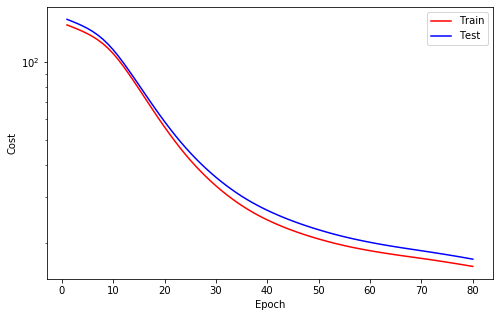



Epoch    81
Train_cost  = 16.0798 | Test_cost  = 17.1488 | 




Epoch    82
Train_cost  = 15.9518 | Test_cost  = 17.0061 | 




Epoch    83
Train_cost  = 15.8221 | Test_cost  = 16.8610 | 




Epoch    84
Train_cost  = 15.6879 | Test_cost  = 16.7091 | 




Epoch    85
Train_cost  = 15.5446 | Test_cost  = 16.5435 | 




Epoch    86
Train_cost  = 15.3843 | Test_cost  = 16.3531 | 




Epoch    87
Train_cost  = 15.1947 | Test_cost  = 16.1226 | 




Epoch    88
Train_cost  = 14.9621 | Test_cost  = 15.8340 | 




Epoch    89
Train_cost  = 14.6784 | Test_cost  = 15.4846 | 




Epoch    90
Train_cost  = 14.3598 | Test_cost  = 15.1175 | 




Epoch    91
Train_cost  = 14.0261 | Test_cost  = 14.7796 | 




Epoch    92
Train_cost  = 13.7120 | Test_cost  = 14.4443 | 




Epoch    93
Train_cost  = 13.3808 | Test_cost  = 14.0881 | 




Epoch    94
Train_cost  = 13.0196 | Test_cost  = 13.6765 | 




Epoch    95
Train_cost  = 12.6459 | Test_cost  = 13.3006 | 




Epoch    96
Train_cost  = 12.3415 | Test_cost  = 13.0052 | 




Epoch    97
Train_cost  = 12.0848 | Test_cost  = 12.7503 | 




Epoch    98
Train_cost  = 11.8462 | Test_cost  = 12.5141 | 




Epoch    99
Train_cost  = 11.6248 | Test_cost  = 12.2907 | 




Epoch   100
Train_cost  = 11.4189 | Test_cost  = 12.0741 | 


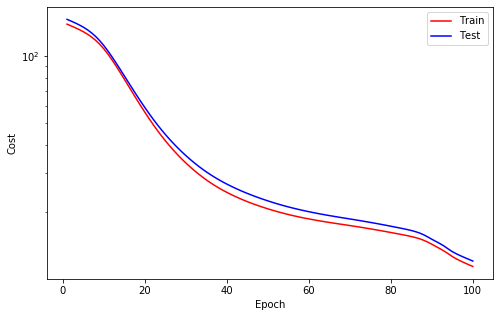



Epoch   101
Train_cost  = 11.2252 | Test_cost  = 11.8609 | 




Epoch   102
Train_cost  = 11.0389 | Test_cost  = 11.6543 | 




Epoch   103
Train_cost  = 10.8592 | Test_cost  = 11.4564 | 




Epoch   104
Train_cost  = 10.6873 | Test_cost  = 11.2661 | 




Epoch   105
Train_cost  = 10.5224 | Test_cost  = 11.0818 | 




Epoch   106
Train_cost  = 10.3634 | Test_cost  = 10.9023 | 




Epoch   107
Train_cost  = 10.2100 | Test_cost  = 10.7286 | 




Epoch   108
Train_cost  = 10.0610 | Test_cost  = 10.5612 | 




Epoch   109
Train_cost  = 9.9164 | Test_cost  = 10.3991 | 




Epoch   110
Train_cost  = 9.7755 | Test_cost  = 10.2409 | 




Epoch   111
Train_cost  = 9.6388 | Test_cost  = 10.0865 | 




Epoch   112
Train_cost  = 9.5065 | Test_cost  = 9.9363 | 




Epoch   113
Train_cost  = 9.3786 | Test_cost  = 9.7904 | 




Epoch   114
Train_cost  = 9.2550 | Test_cost  = 9.6489 | 




Epoch   115
Train_cost  = 9.1352 | Test_cost  = 9.5116 | 




Epoch   116
Train_cost  = 9.0190 | Test_cost  = 9.3785 | 




Epoch   117
Train_cost  = 8.9062 | Test_cost  = 9.2493 | 




Epoch   118
Train_cost  = 8.7966 | Test_cost  = 9.1241 | 




Epoch   119
Train_cost  = 8.6901 | Test_cost  = 9.0025 | 




Epoch   120
Train_cost  = 8.5863 | Test_cost  = 8.8842 | 


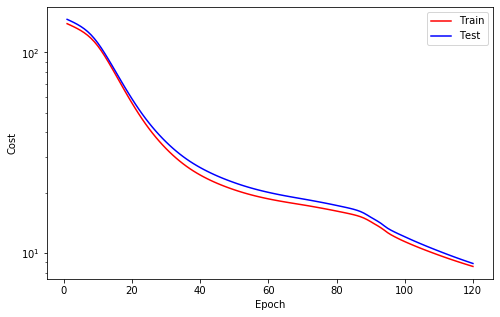



Epoch   121
Train_cost  = 8.4850 | Test_cost  = 8.7690 | 




Epoch   122
Train_cost  = 8.3861 | Test_cost  = 8.6575 | 




Epoch   123
Train_cost  = 8.2904 | Test_cost  = 8.5500 | 




Epoch   124
Train_cost  = 8.1985 | Test_cost  = 8.4459 | 




Epoch   125
Train_cost  = 8.1099 | Test_cost  = 8.3445 | 




Epoch   126
Train_cost  = 8.0239 | Test_cost  = 8.2457 | 




Epoch   127
Train_cost  = 7.9399 | Test_cost  = 8.1495 | 




Epoch   128
Train_cost  = 7.8579 | Test_cost  = 8.0558 | 




Epoch   129
Train_cost  = 7.7777 | Test_cost  = 7.9642 | 




Epoch   130
Train_cost  = 7.6989 | Test_cost  = 7.8744 | 




Epoch   131
Train_cost  = 7.6216 | Test_cost  = 7.7865 | 




Epoch   132
Train_cost  = 7.5455 | Test_cost  = 7.7005 | 




Epoch   133
Train_cost  = 7.4709 | Test_cost  = 7.6162 | 




Epoch   134
Train_cost  = 7.3978 | Test_cost  = 7.5337 | 




Epoch   135
Train_cost  = 7.3260 | Test_cost  = 7.4532 | 




Epoch   136
Train_cost  = 7.2554 | Test_cost  = 7.3741 | 




Epoch   137
Train_cost  = 7.1862 | Test_cost  = 7.2958 | 




Epoch   138
Train_cost  = 7.1183 | Test_cost  = 7.2187 | 




Epoch   139
Train_cost  = 7.0514 | Test_cost  = 7.1428 | 




Epoch   140
Train_cost  = 6.9857 | Test_cost  = 7.0681 | 


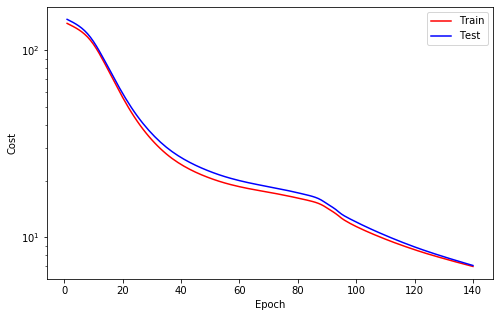



Epoch   141
Train_cost  = 6.9209 | Test_cost  = 6.9947 | 




Epoch   142
Train_cost  = 6.8570 | Test_cost  = 6.9226 | 




Epoch   143
Train_cost  = 6.7939 | Test_cost  = 6.8518 | 




Epoch   144
Train_cost  = 6.7317 | Test_cost  = 6.7821 | 




Epoch   145
Train_cost  = 6.6701 | Test_cost  = 6.7135 | 




Epoch   146
Train_cost  = 6.6092 | Test_cost  = 6.6459 | 




Epoch   147
Train_cost  = 6.5490 | Test_cost  = 6.5795 | 




Epoch   148
Train_cost  = 6.4897 | Test_cost  = 6.5140 | 




Epoch   149
Train_cost  = 6.4316 | Test_cost  = 6.4490 | 




Epoch   150
Train_cost  = 6.3744 | Test_cost  = 6.3848 | 




Epoch   151
Train_cost  = 6.3181 | Test_cost  = 6.3214 | 




Epoch   152
Train_cost  = 6.2625 | Test_cost  = 6.2588 | 




Epoch   153
Train_cost  = 6.2077 | Test_cost  = 6.1971 | 




Epoch   154
Train_cost  = 6.1536 | Test_cost  = 6.1361 | 




Epoch   155
Train_cost  = 6.1000 | Test_cost  = 6.0759 | 




Epoch   156
Train_cost  = 6.0471 | Test_cost  = 6.0161 | 




Epoch   157
Train_cost  = 5.9946 | Test_cost  = 5.9570 | 




Epoch   158
Train_cost  = 5.9427 | Test_cost  = 5.8983 | 




Epoch   159
Train_cost  = 5.8911 | Test_cost  = 5.8402 | 




Epoch   160
Train_cost  = 5.8400 | Test_cost  = 5.7826 | 


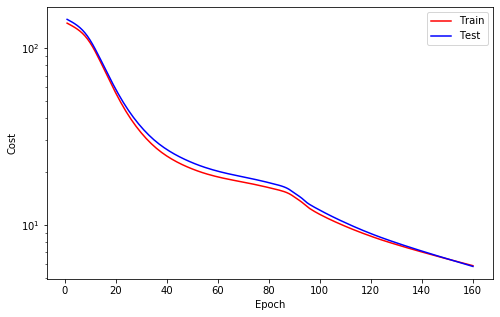



Epoch   161
Train_cost  = 5.7893 | Test_cost  = 5.7254 | 




Epoch   162
Train_cost  = 5.7389 | Test_cost  = 5.6686 | 




Epoch   163
Train_cost  = 5.6889 | Test_cost  = 5.6121 | 




Epoch   164
Train_cost  = 5.6393 | Test_cost  = 5.5560 | 




Epoch   165
Train_cost  = 5.5898 | Test_cost  = 5.5000 | 




Epoch   166
Train_cost  = 5.5406 | Test_cost  = 5.4443 | 




Epoch   167
Train_cost  = 5.4914 | Test_cost  = 5.3888 | 




Epoch   168
Train_cost  = 5.4423 | Test_cost  = 5.3335 | 




Epoch   169
Train_cost  = 5.3933 | Test_cost  = 5.2785 | 




Epoch   170
Train_cost  = 5.3442 | Test_cost  = 5.2238 | 




Epoch   171
Train_cost  = 5.2951 | Test_cost  = 5.1694 | 




Epoch   172
Train_cost  = 5.2461 | Test_cost  = 5.1155 | 




Epoch   173
Train_cost  = 5.1972 | Test_cost  = 5.0619 | 




Epoch   174
Train_cost  = 5.1485 | Test_cost  = 5.0088 | 




Epoch   175
Train_cost  = 5.0999 | Test_cost  = 4.9561 | 




Epoch   176
Train_cost  = 5.0515 | Test_cost  = 4.9038 | 




Epoch   177
Train_cost  = 5.0033 | Test_cost  = 4.8520 | 




Epoch   178
Train_cost  = 4.9552 | Test_cost  = 4.8006 | 




Epoch   179
Train_cost  = 4.9074 | Test_cost  = 4.7497 | 




Epoch   180
Train_cost  = 4.8600 | Test_cost  = 4.6992 | 


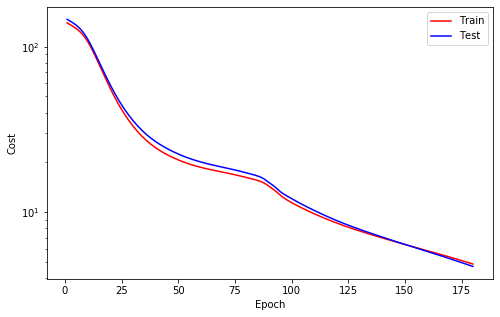



Epoch   181
Train_cost  = 4.8130 | Test_cost  = 4.6490 | 




Epoch   182
Train_cost  = 4.7665 | Test_cost  = 4.5993 | 




Epoch   183
Train_cost  = 4.7205 | Test_cost  = 4.5499 | 




Epoch   184
Train_cost  = 4.6750 | Test_cost  = 4.5010 | 




Epoch   185
Train_cost  = 4.6300 | Test_cost  = 4.4526 | 




Epoch   186
Train_cost  = 4.5854 | Test_cost  = 4.4046 | 




Epoch   187
Train_cost  = 4.5413 | Test_cost  = 4.3570 | 




Epoch   188
Train_cost  = 4.4976 | Test_cost  = 4.3099 | 




Epoch   189
Train_cost  = 4.4542 | Test_cost  = 4.2633 | 




Epoch   190
Train_cost  = 4.4112 | Test_cost  = 4.2170 | 




Epoch   191
Train_cost  = 4.3685 | Test_cost  = 4.1711 | 




Epoch   192
Train_cost  = 4.3261 | Test_cost  = 4.1256 | 




Epoch   193
Train_cost  = 4.2839 | Test_cost  = 4.0805 | 




Epoch   194
Train_cost  = 4.2421 | Test_cost  = 4.0358 | 




Epoch   195
Train_cost  = 4.2006 | Test_cost  = 3.9915 | 




Epoch   196
Train_cost  = 4.1596 | Test_cost  = 3.9479 | 




Epoch   197
Train_cost  = 4.1191 | Test_cost  = 3.9048 | 




Epoch   198
Train_cost  = 4.0792 | Test_cost  = 3.8623 | 




Epoch   199
Train_cost  = 4.0399 | Test_cost  = 3.8204 | 




Epoch   200
Train_cost  = 4.0013 | Test_cost  = 3.7792 | 


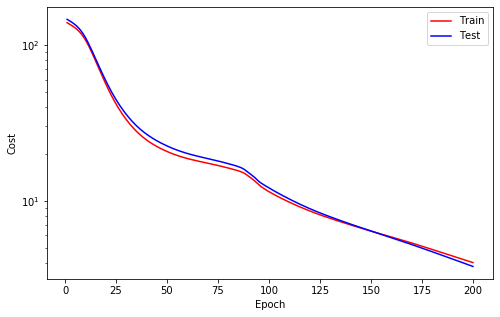



Epoch   201
Train_cost  = 3.9635 | Test_cost  = 3.7385 | 




Epoch   202
Train_cost  = 3.9262 | Test_cost  = 3.6983 | 




Epoch   203
Train_cost  = 3.8896 | Test_cost  = 3.6586 | 




Epoch   204
Train_cost  = 3.8535 | Test_cost  = 3.6193 | 




Epoch   205
Train_cost  = 3.8178 | Test_cost  = 3.5804 | 




Epoch   206
Train_cost  = 3.7825 | Test_cost  = 3.5419 | 




Epoch   207
Train_cost  = 3.7476 | Test_cost  = 3.5037 | 




Epoch   208
Train_cost  = 3.7130 | Test_cost  = 3.4659 | 




Epoch   209
Train_cost  = 3.6787 | Test_cost  = 3.4283 | 




Epoch   210
Train_cost  = 3.6448 | Test_cost  = 3.3911 | 




Epoch   211
Train_cost  = 3.6111 | Test_cost  = 3.3541 | 




Epoch   212
Train_cost  = 3.5776 | Test_cost  = 3.3175 | 




Epoch   213
Train_cost  = 3.5444 | Test_cost  = 3.2811 | 




Epoch   214
Train_cost  = 3.5115 | Test_cost  = 3.2450 | 




Epoch   215
Train_cost  = 3.4788 | Test_cost  = 3.2092 | 




Epoch   216
Train_cost  = 3.4464 | Test_cost  = 3.1735 | 




Epoch   217
Train_cost  = 3.4142 | Test_cost  = 3.1381 | 




Epoch   218
Train_cost  = 3.3822 | Test_cost  = 3.1029 | 




Epoch   219
Train_cost  = 3.3503 | Test_cost  = 3.0680 | 




Epoch   220
Train_cost  = 3.3187 | Test_cost  = 3.0332 | 


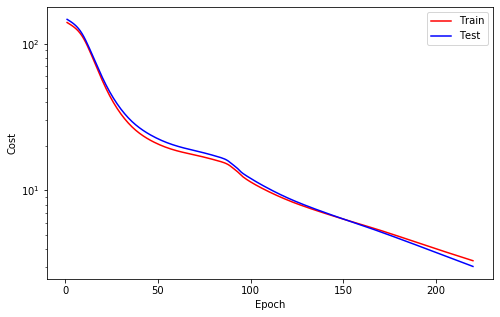



Epoch   221
Train_cost  = 3.2873 | Test_cost  = 2.9987 | 




Epoch   222
Train_cost  = 3.2561 | Test_cost  = 2.9645 | 




Epoch   223
Train_cost  = 3.2250 | Test_cost  = 2.9305 | 




Epoch   224
Train_cost  = 3.1942 | Test_cost  = 2.8967 | 




Epoch   225
Train_cost  = 3.1635 | Test_cost  = 2.8632 | 




Epoch   226
Train_cost  = 3.1330 | Test_cost  = 2.8300 | 




Epoch   227
Train_cost  = 3.1027 | Test_cost  = 2.7971 | 




Epoch   228
Train_cost  = 3.0726 | Test_cost  = 2.7646 | 




Epoch   229
Train_cost  = 3.0427 | Test_cost  = 2.7323 | 




Epoch   230
Train_cost  = 3.0130 | Test_cost  = 2.7003 | 




Epoch   231
Train_cost  = 2.9834 | Test_cost  = 2.6687 | 




Epoch   232
Train_cost  = 2.9540 | Test_cost  = 2.6375 | 




Epoch   233
Train_cost  = 2.9248 | Test_cost  = 2.6065 | 




Epoch   234
Train_cost  = 2.8959 | Test_cost  = 2.5760 | 




Epoch   235
Train_cost  = 2.8671 | Test_cost  = 2.5457 | 




Epoch   236
Train_cost  = 2.8385 | Test_cost  = 2.5159 | 




Epoch   237
Train_cost  = 2.8101 | Test_cost  = 2.4863 | 




Epoch   238
Train_cost  = 2.7819 | Test_cost  = 2.4572 | 




Epoch   239
Train_cost  = 2.7538 | Test_cost  = 2.4284 | 




Epoch   240
Train_cost  = 2.7260 | Test_cost  = 2.3999 | 


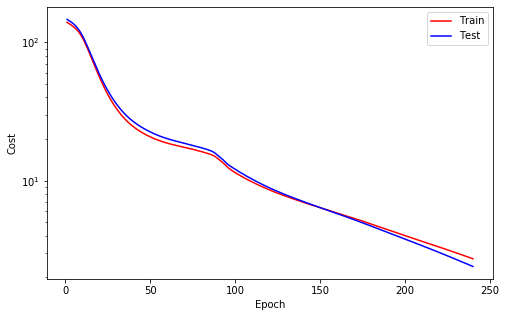



Epoch   241
Train_cost  = 2.6984 | Test_cost  = 2.3718 | 




Epoch   242
Train_cost  = 2.6710 | Test_cost  = 2.3440 | 




Epoch   243
Train_cost  = 2.6439 | Test_cost  = 2.3165 | 




Epoch   244
Train_cost  = 2.6169 | Test_cost  = 2.2894 | 




Epoch   245
Train_cost  = 2.5901 | Test_cost  = 2.2625 | 




Epoch   246
Train_cost  = 2.5636 | Test_cost  = 2.2360 | 




Epoch   247
Train_cost  = 2.5373 | Test_cost  = 2.2098 | 




Epoch   248
Train_cost  = 2.5112 | Test_cost  = 2.1840 | 




Epoch   249
Train_cost  = 2.4853 | Test_cost  = 2.1584 | 




Epoch   250
Train_cost  = 2.4597 | Test_cost  = 2.1331 | 




Epoch   251
Train_cost  = 2.4343 | Test_cost  = 2.1081 | 




Epoch   252
Train_cost  = 2.4092 | Test_cost  = 2.0834 | 




Epoch   253
Train_cost  = 2.3844 | Test_cost  = 2.0589 | 




Epoch   254
Train_cost  = 2.3598 | Test_cost  = 2.0348 | 




Epoch   255
Train_cost  = 2.3354 | Test_cost  = 2.0109 | 




Epoch   256
Train_cost  = 2.3114 | Test_cost  = 1.9873 | 




Epoch   257
Train_cost  = 2.2876 | Test_cost  = 1.9640 | 




Epoch   258
Train_cost  = 2.2640 | Test_cost  = 1.9410 | 




Epoch   259
Train_cost  = 2.2408 | Test_cost  = 1.9182 | 




Epoch   260
Train_cost  = 2.2178 | Test_cost  = 1.8957 | 


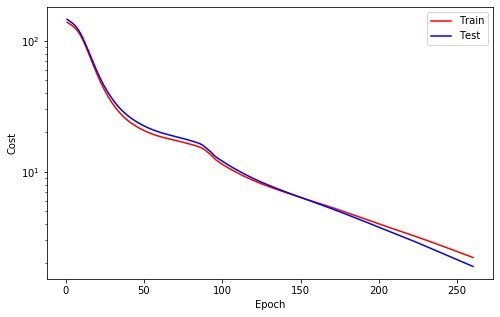



Epoch   261
Train_cost  = 2.1951 | Test_cost  = 1.8734 | 




Epoch   262
Train_cost  = 2.1728 | Test_cost  = 1.8514 | 




Epoch   263
Train_cost  = 2.1506 | Test_cost  = 1.8297 | 




Epoch   264
Train_cost  = 2.1288 | Test_cost  = 1.8083 | 




Epoch   265
Train_cost  = 2.1073 | Test_cost  = 1.7871 | 




Epoch   266
Train_cost  = 2.0861 | Test_cost  = 1.7661 | 




Epoch   267
Train_cost  = 2.0652 | Test_cost  = 1.7454 | 




Epoch   268
Train_cost  = 2.0446 | Test_cost  = 1.7251 | 




Epoch   269
Train_cost  = 2.0244 | Test_cost  = 1.7049 | 




Epoch   270
Train_cost  = 2.0044 | Test_cost  = 1.6851 | 




Epoch   271
Train_cost  = 1.9848 | Test_cost  = 1.6656 | 




Epoch   272
Train_cost  = 1.9655 | Test_cost  = 1.6464 | 




Epoch   273
Train_cost  = 1.9466 | Test_cost  = 1.6275 | 




Epoch   274
Train_cost  = 1.9280 | Test_cost  = 1.6089 | 




Epoch   275
Train_cost  = 1.9097 | Test_cost  = 1.5906 | 




Epoch   276
Train_cost  = 1.8918 | Test_cost  = 1.5726 | 




Epoch   277
Train_cost  = 1.8742 | Test_cost  = 1.5550 | 




Epoch   278
Train_cost  = 1.8569 | Test_cost  = 1.5377 | 




Epoch   279
Train_cost  = 1.8400 | Test_cost  = 1.5207 | 




Epoch   280
Train_cost  = 1.8235 | Test_cost  = 1.5040 | 


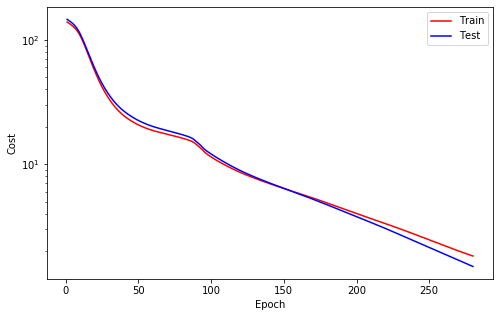



Epoch   281
Train_cost  = 1.8072 | Test_cost  = 1.4876 | 




Epoch   282
Train_cost  = 1.7914 | Test_cost  = 1.4716 | 




Epoch   283
Train_cost  = 1.7758 | Test_cost  = 1.4558 | 




Epoch   284
Train_cost  = 1.7606 | Test_cost  = 1.4404 | 




Epoch   285
Train_cost  = 1.7456 | Test_cost  = 1.4253 | 




Epoch   286
Train_cost  = 1.7310 | Test_cost  = 1.4105 | 




Epoch   287
Train_cost  = 1.7167 | Test_cost  = 1.3959 | 




Epoch   288
Train_cost  = 1.7027 | Test_cost  = 1.3817 | 




Epoch   289
Train_cost  = 1.6890 | Test_cost  = 1.3677 | 




Epoch   290
Train_cost  = 1.6755 | Test_cost  = 1.3540 | 




Epoch   291
Train_cost  = 1.6624 | Test_cost  = 1.3406 | 




Epoch   292
Train_cost  = 1.6495 | Test_cost  = 1.3274 | 




Epoch   293
Train_cost  = 1.6368 | Test_cost  = 1.3145 | 




Epoch   294
Train_cost  = 1.6244 | Test_cost  = 1.3018 | 




Epoch   295
Train_cost  = 1.6122 | Test_cost  = 1.2894 | 




Epoch   296
Train_cost  = 1.6003 | Test_cost  = 1.2771 | 




Epoch   297
Train_cost  = 1.5886 | Test_cost  = 1.2651 | 




Epoch   298
Train_cost  = 1.5771 | Test_cost  = 1.2533 | 




Epoch   299
Train_cost  = 1.5658 | Test_cost  = 1.2417 | 




Epoch   300
Train_cost  = 1.5547 | Test_cost  = 1.2303 | 


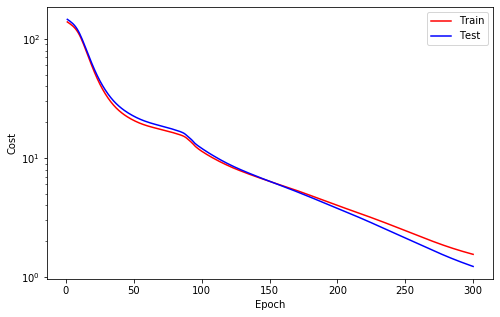



Epoch   301
Train_cost  = 1.5438 | Test_cost  = 1.2191 | 




Epoch   302
Train_cost  = 1.5331 | Test_cost  = 1.2080 | 




Epoch   303
Train_cost  = 1.5225 | Test_cost  = 1.1972 | 




Epoch   304
Train_cost  = 1.5121 | Test_cost  = 1.1865 | 




Epoch   305
Train_cost  = 1.5019 | Test_cost  = 1.1760 | 




Epoch   306
Train_cost  = 1.4919 | Test_cost  = 1.1656 | 




Epoch   307
Train_cost  = 1.4820 | Test_cost  = 1.1554 | 




Epoch   308
Train_cost  = 1.4722 | Test_cost  = 1.1454 | 




Epoch   309
Train_cost  = 1.4626 | Test_cost  = 1.1355 | 




Epoch   310
Train_cost  = 1.4531 | Test_cost  = 1.1257 | 




Epoch   311
Train_cost  = 1.4438 | Test_cost  = 1.1161 | 




Epoch   312
Train_cost  = 1.4346 | Test_cost  = 1.1066 | 




Epoch   313
Train_cost  = 1.4255 | Test_cost  = 1.0972 | 




Epoch   314
Train_cost  = 1.4165 | Test_cost  = 1.0880 | 




Epoch   315
Train_cost  = 1.4076 | Test_cost  = 1.0788 | 




Epoch   316
Train_cost  = 1.3989 | Test_cost  = 1.0698 | 




Epoch   317
Train_cost  = 1.3903 | Test_cost  = 1.0610 | 




Epoch   318
Train_cost  = 1.3817 | Test_cost  = 1.0522 | 




Epoch   319
Train_cost  = 1.3733 | Test_cost  = 1.0435 | 




Epoch   320
Train_cost  = 1.3650 | Test_cost  = 1.0350 | 


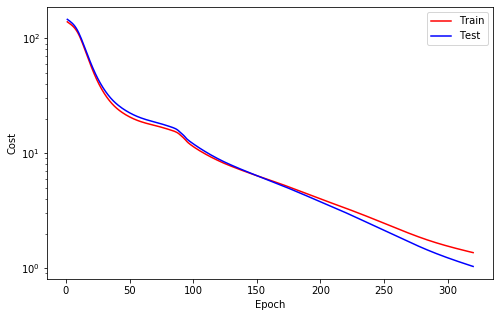



Epoch   321
Train_cost  = 1.3568 | Test_cost  = 1.0266 | 




Epoch   322
Train_cost  = 1.3486 | Test_cost  = 1.0182 | 




Epoch   323
Train_cost  = 1.3406 | Test_cost  = 1.0100 | 




Epoch   324
Train_cost  = 1.3327 | Test_cost  = 1.0019 | 




Epoch   325
Train_cost  = 1.3248 | Test_cost  = 0.9939 | 




Epoch   326
Train_cost  = 1.3171 | Test_cost  = 0.9860 | 




Epoch   327
Train_cost  = 1.3094 | Test_cost  = 0.9781 | 




Epoch   328
Train_cost  = 1.3018 | Test_cost  = 0.9704 | 




Epoch   329
Train_cost  = 1.2943 | Test_cost  = 0.9628 | 




Epoch   330
Train_cost  = 1.2869 | Test_cost  = 0.9553 | 




Epoch   331
Train_cost  = 1.2796 | Test_cost  = 0.9478 | 




Epoch   332
Train_cost  = 1.2723 | Test_cost  = 0.9405 | 




Epoch   333
Train_cost  = 1.2652 | Test_cost  = 0.9332 | 




Epoch   334
Train_cost  = 1.2581 | Test_cost  = 0.9260 | 




Epoch   335
Train_cost  = 1.2511 | Test_cost  = 0.9189 | 




Epoch   336
Train_cost  = 1.2441 | Test_cost  = 0.9119 | 




Epoch   337
Train_cost  = 1.2372 | Test_cost  = 0.9050 | 




Epoch   338
Train_cost  = 1.2304 | Test_cost  = 0.8981 | 




Epoch   339
Train_cost  = 1.2237 | Test_cost  = 0.8914 | 




Epoch   340
Train_cost  = 1.2171 | Test_cost  = 0.8847 | 


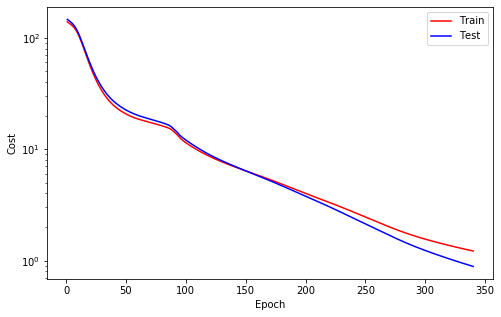



Epoch   341
Train_cost  = 1.2105 | Test_cost  = 0.8781 | 




Epoch   342
Train_cost  = 1.2040 | Test_cost  = 0.8716 | 




Epoch   343
Train_cost  = 1.1975 | Test_cost  = 0.8651 | 




Epoch   344
Train_cost  = 1.1911 | Test_cost  = 0.8588 | 




Epoch   345
Train_cost  = 1.1848 | Test_cost  = 0.8525 | 




Epoch   346
Train_cost  = 1.1786 | Test_cost  = 0.8463 | 




Epoch   347
Train_cost  = 1.1724 | Test_cost  = 0.8401 | 




Epoch   348
Train_cost  = 1.1662 | Test_cost  = 0.8340 | 




Epoch   349
Train_cost  = 1.1602 | Test_cost  = 0.8280 | 




Epoch   350
Train_cost  = 1.1542 | Test_cost  = 0.8221 | 




Epoch   351
Train_cost  = 1.1482 | Test_cost  = 0.8163 | 




Epoch   352
Train_cost  = 1.1424 | Test_cost  = 0.8105 | 




Epoch   353
Train_cost  = 1.1365 | Test_cost  = 0.8047 | 




Epoch   354
Train_cost  = 1.1308 | Test_cost  = 0.7991 | 




Epoch   355
Train_cost  = 1.1251 | Test_cost  = 0.7935 | 




Epoch   356
Train_cost  = 1.1194 | Test_cost  = 0.7880 | 




Epoch   357
Train_cost  = 1.1138 | Test_cost  = 0.7825 | 




Epoch   358
Train_cost  = 1.1083 | Test_cost  = 0.7771 | 




Epoch   359
Train_cost  = 1.1029 | Test_cost  = 0.7718 | 




Epoch   360
Train_cost  = 1.0974 | Test_cost  = 0.7665 | 


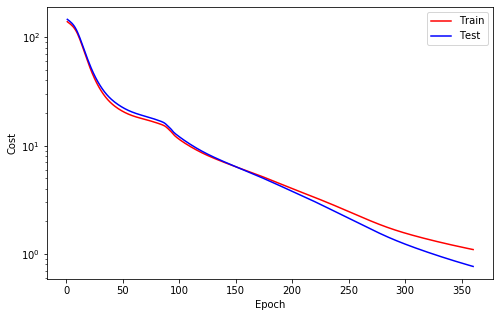



Epoch   361
Train_cost  = 1.0921 | Test_cost  = 0.7613 | 




Epoch   362
Train_cost  = 1.0868 | Test_cost  = 0.7562 | 




Epoch   363
Train_cost  = 1.0815 | Test_cost  = 0.7511 | 




Epoch   364
Train_cost  = 1.0763 | Test_cost  = 0.7461 | 




Epoch   365
Train_cost  = 1.0712 | Test_cost  = 0.7411 | 




Epoch   366
Train_cost  = 1.0661 | Test_cost  = 0.7363 | 




Epoch   367
Train_cost  = 1.0611 | Test_cost  = 0.7314 | 




Epoch   368
Train_cost  = 1.0561 | Test_cost  = 0.7266 | 




Epoch   369
Train_cost  = 1.0511 | Test_cost  = 0.7219 | 




Epoch   370
Train_cost  = 1.0463 | Test_cost  = 0.7173 | 




Epoch   371
Train_cost  = 1.0414 | Test_cost  = 0.7127 | 




Epoch   372
Train_cost  = 1.0366 | Test_cost  = 0.7081 | 




Epoch   373
Train_cost  = 1.0319 | Test_cost  = 0.7036 | 




Epoch   374
Train_cost  = 1.0272 | Test_cost  = 0.6992 | 




Epoch   375
Train_cost  = 1.0225 | Test_cost  = 0.6948 | 




Epoch   376
Train_cost  = 1.0179 | Test_cost  = 0.6904 | 




Epoch   377
Train_cost  = 1.0133 | Test_cost  = 0.6861 | 




Epoch   378
Train_cost  = 1.0087 | Test_cost  = 0.6819 | 




Epoch   379
Train_cost  = 1.0042 | Test_cost  = 0.6777 | 




Epoch   380
Train_cost  = 0.9998 | Test_cost  = 0.6736 | 


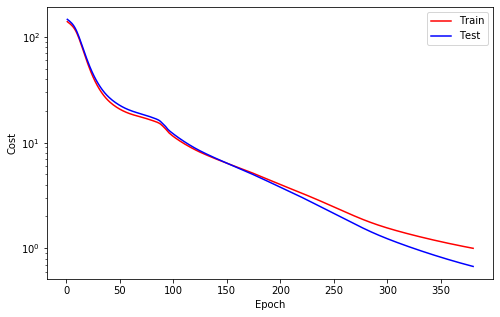



Epoch   381
Train_cost  = 0.9954 | Test_cost  = 0.6695 | 




Epoch   382
Train_cost  = 0.9910 | Test_cost  = 0.6655 | 




Epoch   383
Train_cost  = 0.9866 | Test_cost  = 0.6615 | 




Epoch   384
Train_cost  = 0.9823 | Test_cost  = 0.6576 | 




Epoch   385
Train_cost  = 0.9781 | Test_cost  = 0.6537 | 




Epoch   386
Train_cost  = 0.9738 | Test_cost  = 0.6499 | 




Epoch   387
Train_cost  = 0.9697 | Test_cost  = 0.6461 | 




Epoch   388
Train_cost  = 0.9655 | Test_cost  = 0.6423 | 




Epoch   389
Train_cost  = 0.9614 | Test_cost  = 0.6386 | 




Epoch   390
Train_cost  = 0.9573 | Test_cost  = 0.6350 | 




Epoch   391
Train_cost  = 0.9533 | Test_cost  = 0.6314 | 




Epoch   392
Train_cost  = 0.9493 | Test_cost  = 0.6278 | 




Epoch   393
Train_cost  = 0.9454 | Test_cost  = 0.6243 | 




Epoch   394
Train_cost  = 0.9414 | Test_cost  = 0.6209 | 




Epoch   395
Train_cost  = 0.9375 | Test_cost  = 0.6175 | 




Epoch   396
Train_cost  = 0.9337 | Test_cost  = 0.6141 | 




Epoch   397
Train_cost  = 0.9299 | Test_cost  = 0.6108 | 




Epoch   398
Train_cost  = 0.9261 | Test_cost  = 0.6075 | 




Epoch   399
Train_cost  = 0.9223 | Test_cost  = 0.6042 | 




Epoch   400
Train_cost  = 0.9186 | Test_cost  = 0.6010 | 


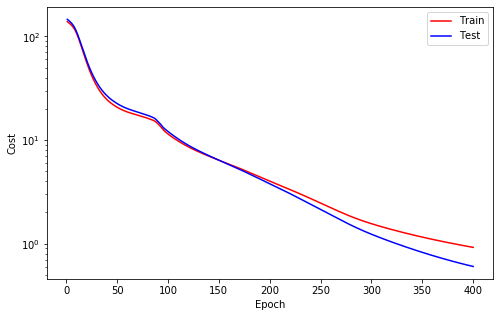



Epoch   401
Train_cost  = 0.9149 | Test_cost  = 0.5979 | 




Epoch   402
Train_cost  = 0.9113 | Test_cost  = 0.5948 | 




Epoch   403
Train_cost  = 0.9077 | Test_cost  = 0.5917 | 




Epoch   404
Train_cost  = 0.9041 | Test_cost  = 0.5887 | 




Epoch   405
Train_cost  = 0.9005 | Test_cost  = 0.5857 | 




Epoch   406
Train_cost  = 0.8970 | Test_cost  = 0.5827 | 




Epoch   407
Train_cost  = 0.8935 | Test_cost  = 0.5798 | 




Epoch   408
Train_cost  = 0.8900 | Test_cost  = 0.5769 | 




Epoch   409
Train_cost  = 0.8865 | Test_cost  = 0.5740 | 




Epoch   410
Train_cost  = 0.8831 | Test_cost  = 0.5712 | 




Epoch   411
Train_cost  = 0.8797 | Test_cost  = 0.5684 | 




Epoch   412
Train_cost  = 0.8764 | Test_cost  = 0.5657 | 




Epoch   413
Train_cost  = 0.8730 | Test_cost  = 0.5629 | 




Epoch   414
Train_cost  = 0.8697 | Test_cost  = 0.5603 | 




Epoch   415
Train_cost  = 0.8664 | Test_cost  = 0.5576 | 




Epoch   416
Train_cost  = 0.8632 | Test_cost  = 0.5550 | 




Epoch   417
Train_cost  = 0.8599 | Test_cost  = 0.5524 | 




Epoch   418
Train_cost  = 0.8567 | Test_cost  = 0.5498 | 




Epoch   419
Train_cost  = 0.8535 | Test_cost  = 0.5473 | 




Epoch   420
Train_cost  = 0.8504 | Test_cost  = 0.5448 | 


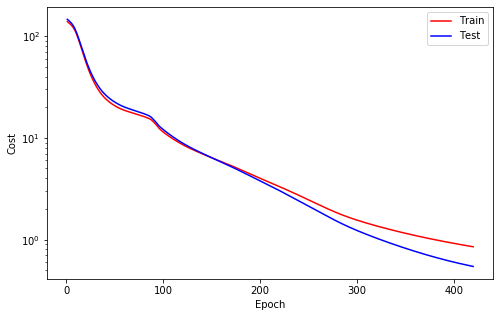



Epoch   421
Train_cost  = 0.8472 | Test_cost  = 0.5423 | 




Epoch   422
Train_cost  = 0.8441 | Test_cost  = 0.5398 | 




Epoch   423
Train_cost  = 0.8410 | Test_cost  = 0.5374 | 




Epoch   424
Train_cost  = 0.8380 | Test_cost  = 0.5350 | 




Epoch   425
Train_cost  = 0.8349 | Test_cost  = 0.5326 | 




Epoch   426
Train_cost  = 0.8319 | Test_cost  = 0.5302 | 




Epoch   427
Train_cost  = 0.8289 | Test_cost  = 0.5279 | 




Epoch   428
Train_cost  = 0.8260 | Test_cost  = 0.5256 | 




Epoch   429
Train_cost  = 0.8230 | Test_cost  = 0.5233 | 




Epoch   430
Train_cost  = 0.8201 | Test_cost  = 0.5210 | 




Epoch   431
Train_cost  = 0.8172 | Test_cost  = 0.5188 | 




Epoch   432
Train_cost  = 0.8143 | Test_cost  = 0.5166 | 




Epoch   433
Train_cost  = 0.8115 | Test_cost  = 0.5144 | 




Epoch   434
Train_cost  = 0.8086 | Test_cost  = 0.5122 | 




Epoch   435
Train_cost  = 0.8058 | Test_cost  = 0.5101 | 




Epoch   436
Train_cost  = 0.8030 | Test_cost  = 0.5080 | 




Epoch   437
Train_cost  = 0.8003 | Test_cost  = 0.5059 | 




Epoch   438
Train_cost  = 0.7975 | Test_cost  = 0.5038 | 




Epoch   439
Train_cost  = 0.7948 | Test_cost  = 0.5017 | 




Epoch   440
Train_cost  = 0.7921 | Test_cost  = 0.4997 | 


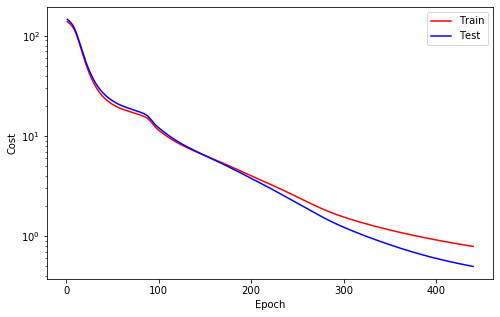



Epoch   441
Train_cost  = 0.7894 | Test_cost  = 0.4977 | 




Epoch   442
Train_cost  = 0.7867 | Test_cost  = 0.4957 | 




Epoch   443
Train_cost  = 0.7841 | Test_cost  = 0.4937 | 




Epoch   444
Train_cost  = 0.7814 | Test_cost  = 0.4918 | 




Epoch   445
Train_cost  = 0.7788 | Test_cost  = 0.4898 | 




Epoch   446
Train_cost  = 0.7762 | Test_cost  = 0.4879 | 




Epoch   447
Train_cost  = 0.7736 | Test_cost  = 0.4860 | 




Epoch   448
Train_cost  = 0.7711 | Test_cost  = 0.4841 | 




Epoch   449
Train_cost  = 0.7685 | Test_cost  = 0.4823 | 




Epoch   450
Train_cost  = 0.7660 | Test_cost  = 0.4805 | 




Epoch   451
Train_cost  = 0.7635 | Test_cost  = 0.4786 | 




Epoch   452
Train_cost  = 0.7610 | Test_cost  = 0.4769 | 




Epoch   453
Train_cost  = 0.7586 | Test_cost  = 0.4751 | 




Epoch   454
Train_cost  = 0.7561 | Test_cost  = 0.4733 | 




Epoch   455
Train_cost  = 0.7537 | Test_cost  = 0.4716 | 




Epoch   456
Train_cost  = 0.7513 | Test_cost  = 0.4699 | 




Epoch   457
Train_cost  = 0.7488 | Test_cost  = 0.4682 | 




Epoch   458
Train_cost  = 0.7465 | Test_cost  = 0.4665 | 




Epoch   459
Train_cost  = 0.7441 | Test_cost  = 0.4648 | 




Epoch   460
Train_cost  = 0.7417 | Test_cost  = 0.4632 | 


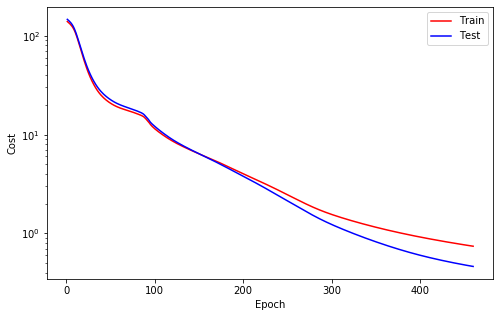



Epoch   461
Train_cost  = 0.7394 | Test_cost  = 0.4615 | 




Epoch   462
Train_cost  = 0.7371 | Test_cost  = 0.4599 | 




Epoch   463
Train_cost  = 0.7347 | Test_cost  = 0.4583 | 




Epoch   464
Train_cost  = 0.7324 | Test_cost  = 0.4567 | 




Epoch   465
Train_cost  = 0.7302 | Test_cost  = 0.4552 | 




Epoch   466
Train_cost  = 0.7279 | Test_cost  = 0.4536 | 




Epoch   467
Train_cost  = 0.7256 | Test_cost  = 0.4521 | 




Epoch   468
Train_cost  = 0.7234 | Test_cost  = 0.4506 | 




Epoch   469
Train_cost  = 0.7212 | Test_cost  = 0.4491 | 




Epoch   470
Train_cost  = 0.7190 | Test_cost  = 0.4476 | 




Epoch   471
Train_cost  = 0.7168 | Test_cost  = 0.4461 | 




Epoch   472
Train_cost  = 0.7146 | Test_cost  = 0.4447 | 




Epoch   473
Train_cost  = 0.7124 | Test_cost  = 0.4432 | 




Epoch   474
Train_cost  = 0.7102 | Test_cost  = 0.4418 | 




Epoch   475
Train_cost  = 0.7081 | Test_cost  = 0.4404 | 




Epoch   476
Train_cost  = 0.7060 | Test_cost  = 0.4390 | 




Epoch   477
Train_cost  = 0.7038 | Test_cost  = 0.4376 | 




Epoch   478
Train_cost  = 0.7017 | Test_cost  = 0.4363 | 




Epoch   479
Train_cost  = 0.6996 | Test_cost  = 0.4349 | 




Epoch   480
Train_cost  = 0.6976 | Test_cost  = 0.4336 | 


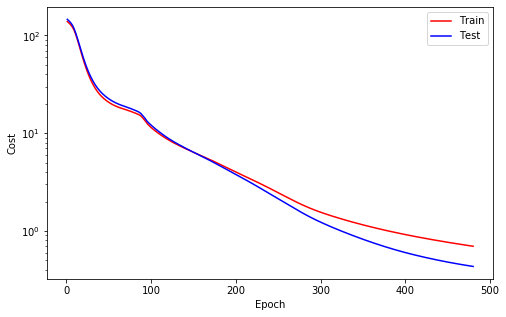



Epoch   481
Train_cost  = 0.6955 | Test_cost  = 0.4323 | 




Epoch   482
Train_cost  = 0.6934 | Test_cost  = 0.4310 | 




Epoch   483
Train_cost  = 0.6914 | Test_cost  = 0.4297 | 




Epoch   484
Train_cost  = 0.6894 | Test_cost  = 0.4284 | 




Epoch   485
Train_cost  = 0.6873 | Test_cost  = 0.4271 | 




Epoch   486
Train_cost  = 0.6853 | Test_cost  = 0.4259 | 




Epoch   487
Train_cost  = 0.6833 | Test_cost  = 0.4246 | 




Epoch   488
Train_cost  = 0.6814 | Test_cost  = 0.4234 | 




Epoch   489
Train_cost  = 0.6794 | Test_cost  = 0.4222 | 




Epoch   490
Train_cost  = 0.6774 | Test_cost  = 0.4210 | 




Epoch   491
Train_cost  = 0.6755 | Test_cost  = 0.4198 | 




Epoch   492
Train_cost  = 0.6735 | Test_cost  = 0.4186 | 




Epoch   493
Train_cost  = 0.6716 | Test_cost  = 0.4174 | 




Epoch   494
Train_cost  = 0.6697 | Test_cost  = 0.4163 | 




Epoch   495
Train_cost  = 0.6678 | Test_cost  = 0.4152 | 




Epoch   496
Train_cost  = 0.6659 | Test_cost  = 0.4140 | 




Epoch   497
Train_cost  = 0.6640 | Test_cost  = 0.4129 | 




Epoch   498
Train_cost  = 0.6622 | Test_cost  = 0.4118 | 




Epoch   499
Train_cost  = 0.6603 | Test_cost  = 0.4107 | 




Epoch   500
Train_cost  = 0.6585 | Test_cost  = 0.4097 | 


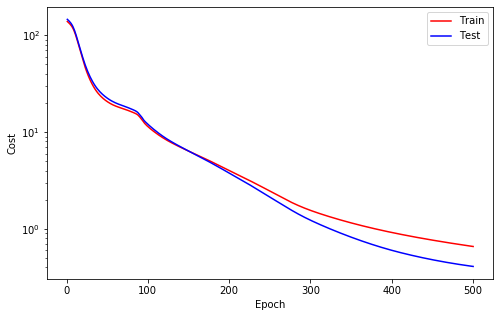



Epoch   501
Train_cost  = 0.6567 | Test_cost  = 0.4086 | 




Epoch   502
Train_cost  = 0.6549 | Test_cost  = 0.4076 | 




Epoch   503
Train_cost  = 0.6531 | Test_cost  = 0.4066 | 




Epoch   504
Train_cost  = 0.6513 | Test_cost  = 0.4056 | 




Epoch   505
Train_cost  = 0.6495 | Test_cost  = 0.4046 | 




Epoch   506
Train_cost  = 0.6478 | Test_cost  = 0.4037 | 




Epoch   507
Train_cost  = 0.6460 | Test_cost  = 0.4027 | 




Epoch   508
Train_cost  = 0.6443 | Test_cost  = 0.4017 | 




Epoch   509
Train_cost  = 0.6425 | Test_cost  = 0.4007 | 




Epoch   510
Train_cost  = 0.6408 | Test_cost  = 0.3998 | 




Epoch   511
Train_cost  = 0.6391 | Test_cost  = 0.3988 | 




Epoch   512
Train_cost  = 0.6373 | Test_cost  = 0.3978 | 




Epoch   513
Train_cost  = 0.6356 | Test_cost  = 0.3968 | 




Epoch   514
Train_cost  = 0.6339 | Test_cost  = 0.3959 | 




Epoch   515
Train_cost  = 0.6321 | Test_cost  = 0.3949 | 




Epoch   516
Train_cost  = 0.6304 | Test_cost  = 0.3939 | 




Epoch   517
Train_cost  = 0.6286 | Test_cost  = 0.3930 | 




Epoch   518
Train_cost  = 0.6269 | Test_cost  = 0.3921 | 




Epoch   519
Train_cost  = 0.6252 | Test_cost  = 0.3912 | 




Epoch   520
Train_cost  = 0.6235 | Test_cost  = 0.3902 | 


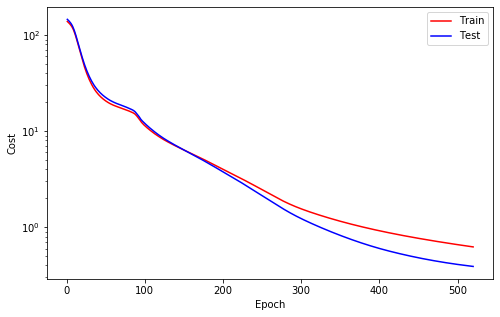



Epoch   521
Train_cost  = 0.6218 | Test_cost  = 0.3894 | 




Epoch   522
Train_cost  = 0.6201 | Test_cost  = 0.3885 | 




Epoch   523
Train_cost  = 0.6184 | Test_cost  = 0.3876 | 




Epoch   524
Train_cost  = 0.6168 | Test_cost  = 0.3867 | 




Epoch   525
Train_cost  = 0.6151 | Test_cost  = 0.3859 | 




Epoch   526
Train_cost  = 0.6135 | Test_cost  = 0.3850 | 




Epoch   527
Train_cost  = 0.6119 | Test_cost  = 0.3842 | 




Epoch   528
Train_cost  = 0.6103 | Test_cost  = 0.3834 | 




Epoch   529
Train_cost  = 0.6087 | Test_cost  = 0.3825 | 




Epoch   530
Train_cost  = 0.6071 | Test_cost  = 0.3817 | 




Epoch   531
Train_cost  = 0.6055 | Test_cost  = 0.3809 | 




Epoch   532
Train_cost  = 0.6040 | Test_cost  = 0.3801 | 




Epoch   533
Train_cost  = 0.6024 | Test_cost  = 0.3793 | 




Epoch   534
Train_cost  = 0.6009 | Test_cost  = 0.3786 | 




Epoch   535
Train_cost  = 0.5993 | Test_cost  = 0.3778 | 




Epoch   536
Train_cost  = 0.5978 | Test_cost  = 0.3770 | 




Epoch   537
Train_cost  = 0.5962 | Test_cost  = 0.3763 | 




Epoch   538
Train_cost  = 0.5947 | Test_cost  = 0.3756 | 




Epoch   539
Train_cost  = 0.5932 | Test_cost  = 0.3748 | 




Epoch   540
Train_cost  = 0.5917 | Test_cost  = 0.3741 | 


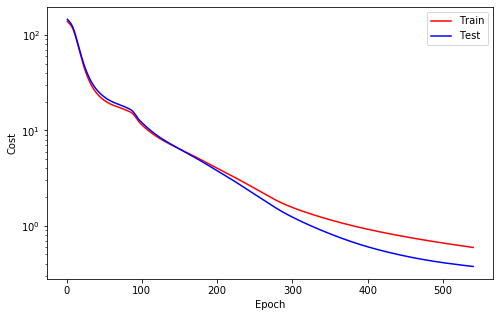



Epoch   541
Train_cost  = 0.5902 | Test_cost  = 0.3734 | 




Epoch   542
Train_cost  = 0.5887 | Test_cost  = 0.3727 | 




Epoch   543
Train_cost  = 0.5872 | Test_cost  = 0.3720 | 




Epoch   544
Train_cost  = 0.5858 | Test_cost  = 0.3713 | 




Epoch   545
Train_cost  = 0.5843 | Test_cost  = 0.3707 | 




Epoch   546
Train_cost  = 0.5829 | Test_cost  = 0.3700 | 




Epoch   547
Train_cost  = 0.5814 | Test_cost  = 0.3693 | 




Epoch   548
Train_cost  = 0.5800 | Test_cost  = 0.3687 | 




Epoch   549
Train_cost  = 0.5786 | Test_cost  = 0.3681 | 




Epoch   550
Train_cost  = 0.5772 | Test_cost  = 0.3674 | 




Epoch   551
Train_cost  = 0.5758 | Test_cost  = 0.3668 | 




Epoch   552
Train_cost  = 0.5744 | Test_cost  = 0.3662 | 




Epoch   553
Train_cost  = 0.5730 | Test_cost  = 0.3656 | 




Epoch   554
Train_cost  = 0.5716 | Test_cost  = 0.3650 | 




Epoch   555
Train_cost  = 0.5702 | Test_cost  = 0.3644 | 




Epoch   556
Train_cost  = 0.5688 | Test_cost  = 0.3639 | 




Epoch   557
Train_cost  = 0.5675 | Test_cost  = 0.3633 | 




Epoch   558
Train_cost  = 0.5661 | Test_cost  = 0.3627 | 




Epoch   559
Train_cost  = 0.5648 | Test_cost  = 0.3622 | 




Epoch   560
Train_cost  = 0.5634 | Test_cost  = 0.3616 | 


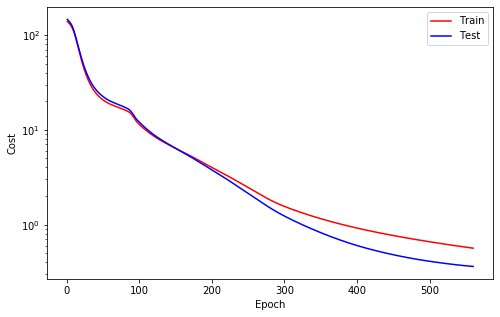



Epoch   561
Train_cost  = 0.5621 | Test_cost  = 0.3611 | 




Epoch   562
Train_cost  = 0.5608 | Test_cost  = 0.3606 | 




Epoch   563
Train_cost  = 0.5594 | Test_cost  = 0.3600 | 




Epoch   564
Train_cost  = 0.5581 | Test_cost  = 0.3595 | 




Epoch   565
Train_cost  = 0.5568 | Test_cost  = 0.3590 | 




Epoch   566
Train_cost  = 0.5555 | Test_cost  = 0.3585 | 




Epoch   567
Train_cost  = 0.5542 | Test_cost  = 0.3580 | 




Epoch   568
Train_cost  = 0.5530 | Test_cost  = 0.3575 | 




Epoch   569
Train_cost  = 0.5517 | Test_cost  = 0.3571 | 




Epoch   570
Train_cost  = 0.5504 | Test_cost  = 0.3566 | 




Epoch   571
Train_cost  = 0.5492 | Test_cost  = 0.3561 | 




Epoch   572
Train_cost  = 0.5479 | Test_cost  = 0.3556 | 




Epoch   573
Train_cost  = 0.5467 | Test_cost  = 0.3552 | 




Epoch   574
Train_cost  = 0.5454 | Test_cost  = 0.3547 | 




Epoch   575
Train_cost  = 0.5442 | Test_cost  = 0.3543 | 




Epoch   576
Train_cost  = 0.5430 | Test_cost  = 0.3539 | 




Epoch   577
Train_cost  = 0.5418 | Test_cost  = 0.3534 | 




Epoch   578
Train_cost  = 0.5405 | Test_cost  = 0.3530 | 




Epoch   579
Train_cost  = 0.5393 | Test_cost  = 0.3526 | 




Epoch   580
Train_cost  = 0.5381 | Test_cost  = 0.3521 | 


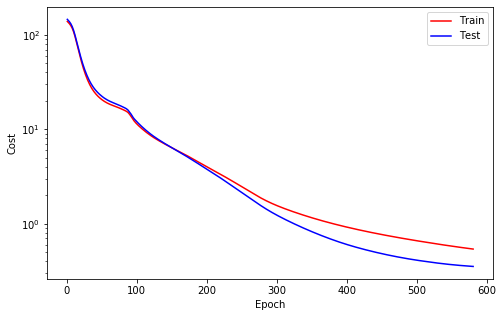



Epoch   581
Train_cost  = 0.5369 | Test_cost  = 0.3517 | 




Epoch   582
Train_cost  = 0.5357 | Test_cost  = 0.3513 | 




Epoch   583
Train_cost  = 0.5346 | Test_cost  = 0.3509 | 




Epoch   584
Train_cost  = 0.5334 | Test_cost  = 0.3505 | 




Epoch   585
Train_cost  = 0.5322 | Test_cost  = 0.3501 | 




Epoch   586
Train_cost  = 0.5310 | Test_cost  = 0.3497 | 




Epoch   587
Train_cost  = 0.5299 | Test_cost  = 0.3494 | 




Epoch   588
Train_cost  = 0.5287 | Test_cost  = 0.3490 | 




Epoch   589
Train_cost  = 0.5276 | Test_cost  = 0.3486 | 




Epoch   590
Train_cost  = 0.5264 | Test_cost  = 0.3482 | 




Epoch   591
Train_cost  = 0.5253 | Test_cost  = 0.3479 | 




Epoch   592
Train_cost  = 0.5242 | Test_cost  = 0.3475 | 




Epoch   593
Train_cost  = 0.5230 | Test_cost  = 0.3472 | 




Epoch   594
Train_cost  = 0.5219 | Test_cost  = 0.3468 | 




Epoch   595
Train_cost  = 0.5208 | Test_cost  = 0.3465 | 




Epoch   596
Train_cost  = 0.5197 | Test_cost  = 0.3461 | 




Epoch   597
Train_cost  = 0.5186 | Test_cost  = 0.3458 | 




Epoch   598
Train_cost  = 0.5175 | Test_cost  = 0.3454 | 




Epoch   599
Train_cost  = 0.5164 | Test_cost  = 0.3451 | 




Epoch   600
Train_cost  = 0.5153 | Test_cost  = 0.3448 | 


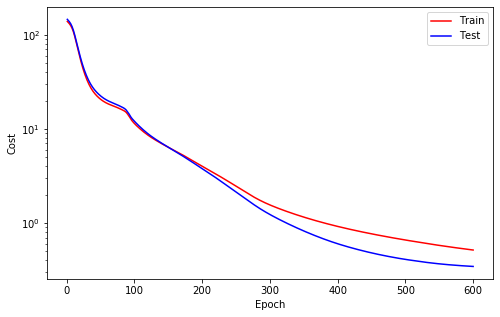



Epoch   601
Train_cost  = 0.5142 | Test_cost  = 0.3444 | 




Epoch   602
Train_cost  = 0.5131 | Test_cost  = 0.3441 | 




Epoch   603
Train_cost  = 0.5121 | Test_cost  = 0.3438 | 




Epoch   604
Train_cost  = 0.5110 | Test_cost  = 0.3435 | 




Epoch   605
Train_cost  = 0.5099 | Test_cost  = 0.3432 | 




Epoch   606
Train_cost  = 0.5089 | Test_cost  = 0.3429 | 




Epoch   607
Train_cost  = 0.5078 | Test_cost  = 0.3425 | 




Epoch   608
Train_cost  = 0.5068 | Test_cost  = 0.3422 | 




Epoch   609
Train_cost  = 0.5057 | Test_cost  = 0.3419 | 




Epoch   610
Train_cost  = 0.5047 | Test_cost  = 0.3416 | 




Epoch   611
Train_cost  = 0.5037 | Test_cost  = 0.3413 | 




Epoch   612
Train_cost  = 0.5026 | Test_cost  = 0.3411 | 




Epoch   613
Train_cost  = 0.5016 | Test_cost  = 0.3408 | 




Epoch   614
Train_cost  = 0.5006 | Test_cost  = 0.3405 | 




Epoch   615
Train_cost  = 0.4996 | Test_cost  = 0.3402 | 




Epoch   616
Train_cost  = 0.4986 | Test_cost  = 0.3399 | 




Epoch   617
Train_cost  = 0.4976 | Test_cost  = 0.3396 | 




Epoch   618
Train_cost  = 0.4965 | Test_cost  = 0.3394 | 




Epoch   619
Train_cost  = 0.4955 | Test_cost  = 0.3391 | 




Epoch   620
Train_cost  = 0.4945 | Test_cost  = 0.3388 | 


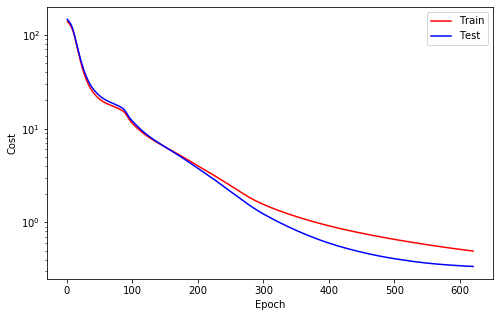



Epoch   621
Train_cost  = 0.4935 | Test_cost  = 0.3386 | 




Epoch   622
Train_cost  = 0.4926 | Test_cost  = 0.3383 | 




Epoch   623
Train_cost  = 0.4916 | Test_cost  = 0.3380 | 




Epoch   624
Train_cost  = 0.4906 | Test_cost  = 0.3378 | 




Epoch   625
Train_cost  = 0.4896 | Test_cost  = 0.3375 | 




Epoch   626
Train_cost  = 0.4886 | Test_cost  = 0.3373 | 




Epoch   627
Train_cost  = 0.4876 | Test_cost  = 0.3370 | 




Epoch   628
Train_cost  = 0.4866 | Test_cost  = 0.3368 | 




Epoch   629
Train_cost  = 0.4857 | Test_cost  = 0.3365 | 




Epoch   630
Train_cost  = 0.4847 | Test_cost  = 0.3363 | 




Epoch   631
Train_cost  = 0.4837 | Test_cost  = 0.3361 | 




Epoch   632
Train_cost  = 0.4828 | Test_cost  = 0.3358 | 




Epoch   633
Train_cost  = 0.4818 | Test_cost  = 0.3356 | 




Epoch   634
Train_cost  = 0.4808 | Test_cost  = 0.3354 | 




Epoch   635
Train_cost  = 0.4799 | Test_cost  = 0.3351 | 




Epoch   636
Train_cost  = 0.4789 | Test_cost  = 0.3349 | 




Epoch   637
Train_cost  = 0.4780 | Test_cost  = 0.3347 | 




Epoch   638
Train_cost  = 0.4770 | Test_cost  = 0.3345 | 




Epoch   639
Train_cost  = 0.4761 | Test_cost  = 0.3343 | 




Epoch   640
Train_cost  = 0.4752 | Test_cost  = 0.3341 | 


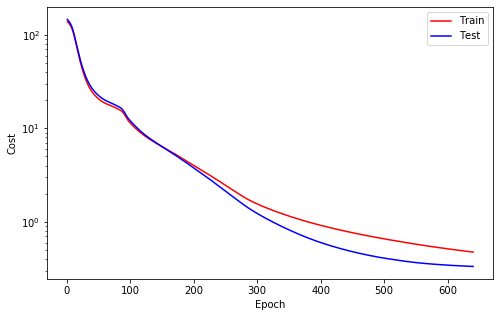



Epoch   641
Train_cost  = 0.4742 | Test_cost  = 0.3339 | 




Epoch   642
Train_cost  = 0.4733 | Test_cost  = 0.3337 | 




Epoch   643
Train_cost  = 0.4724 | Test_cost  = 0.3335 | 




Epoch   644
Train_cost  = 0.4714 | Test_cost  = 0.3333 | 




Epoch   645
Train_cost  = 0.4705 | Test_cost  = 0.3331 | 




Epoch   646
Train_cost  = 0.4696 | Test_cost  = 0.3329 | 




Epoch   647
Train_cost  = 0.4687 | Test_cost  = 0.3327 | 




Epoch   648
Train_cost  = 0.4678 | Test_cost  = 0.3325 | 




Epoch   649
Train_cost  = 0.4669 | Test_cost  = 0.3323 | 




Epoch   650
Train_cost  = 0.4660 | Test_cost  = 0.3321 | 




Epoch   651
Train_cost  = 0.4651 | Test_cost  = 0.3319 | 




Epoch   652
Train_cost  = 0.4642 | Test_cost  = 0.3318 | 




Epoch   653
Train_cost  = 0.4634 | Test_cost  = 0.3316 | 




Epoch   654
Train_cost  = 0.4625 | Test_cost  = 0.3314 | 




Epoch   655
Train_cost  = 0.4617 | Test_cost  = 0.3312 | 




Epoch   656
Train_cost  = 0.4608 | Test_cost  = 0.3310 | 




Epoch   657
Train_cost  = 0.4600 | Test_cost  = 0.3309 | 




Epoch   658
Train_cost  = 0.4591 | Test_cost  = 0.3307 | 




Epoch   659
Train_cost  = 0.4583 | Test_cost  = 0.3305 | 




Epoch   660
Train_cost  = 0.4575 | Test_cost  = 0.3303 | 


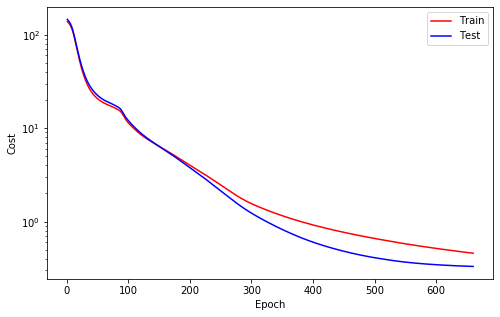



Epoch   661
Train_cost  = 0.4567 | Test_cost  = 0.3302 | 




Epoch   662
Train_cost  = 0.4559 | Test_cost  = 0.3300 | 




Epoch   663
Train_cost  = 0.4551 | Test_cost  = 0.3298 | 




Epoch   664
Train_cost  = 0.4543 | Test_cost  = 0.3297 | 




Epoch   665
Train_cost  = 0.4535 | Test_cost  = 0.3295 | 




Epoch   666
Train_cost  = 0.4527 | Test_cost  = 0.3293 | 




Epoch   667
Train_cost  = 0.4520 | Test_cost  = 0.3291 | 




Epoch   668
Train_cost  = 0.4512 | Test_cost  = 0.3289 | 




Epoch   669
Train_cost  = 0.4504 | Test_cost  = 0.3288 | 




Epoch   670
Train_cost  = 0.4497 | Test_cost  = 0.3286 | 




Epoch   671
Train_cost  = 0.4489 | Test_cost  = 0.3284 | 




Epoch   672
Train_cost  = 0.4482 | Test_cost  = 0.3282 | 




Epoch   673
Train_cost  = 0.4474 | Test_cost  = 0.3280 | 




Epoch   674
Train_cost  = 0.4467 | Test_cost  = 0.3278 | 




Epoch   675
Train_cost  = 0.4459 | Test_cost  = 0.3276 | 




Epoch   676
Train_cost  = 0.4451 | Test_cost  = 0.3275 | 




Epoch   677
Train_cost  = 0.4443 | Test_cost  = 0.3273 | 




Epoch   678
Train_cost  = 0.4435 | Test_cost  = 0.3271 | 




Epoch   679
Train_cost  = 0.4426 | Test_cost  = 0.3270 | 




Epoch   680
Train_cost  = 0.4417 | Test_cost  = 0.3269 | 


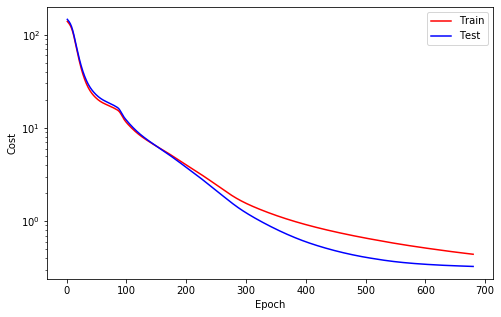



Epoch   681
Train_cost  = 0.4408 | Test_cost  = 0.3268 | 




Epoch   682
Train_cost  = 0.4398 | Test_cost  = 0.3267 | 




Epoch   683
Train_cost  = 0.4388 | Test_cost  = 0.3267 | 




Epoch   684
Train_cost  = 0.4379 | Test_cost  = 0.3267 | 




Epoch   685
Train_cost  = 0.4369 | Test_cost  = 0.3266 | 




Epoch   686
Train_cost  = 0.4361 | Test_cost  = 0.3266 | 




Epoch   687
Train_cost  = 0.4355 | Test_cost  = 0.3266 | 




Epoch   688
Train_cost  = 0.4351 | Test_cost  = 0.3266 | 




Epoch   689
Train_cost  = 0.4349 | Test_cost  = 0.3266 | 
==> EarlyStop patience =  1 | Best test_cost: 0.3266




Epoch   690
Train_cost  = 0.4352 | Test_cost  = 0.3269 | 
==> EarlyStop patience =  2 | Best test_cost: 0.3266




Epoch   691
Train_cost  = 0.4359 | Test_cost  = 0.3275 | 
==> EarlyStop patience =  3 | Best test_cost: 0.3266




Epoch   692
Train_cost  = 0.4373 | Test_cost  = 0.3286 | 
==> EarlyStop patience =  4 | Best test_cost: 0.3266




Epoch   693
Train_cost  = 0.4397 | Test_cost  = 0.3306 | 
==> EarlyStop patience =  5 | Best test_cost: 0.3266
==> Execute Early Stopping at epoch: 693 | Best test_cost: 0.3266
==> Best model is saved at model/Bilstm


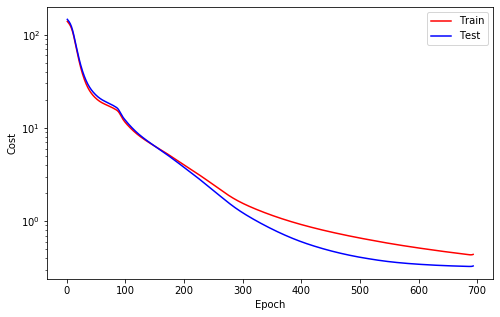

In [38]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

# Sanity Check

In [39]:
from luwiji.rnn import illustration

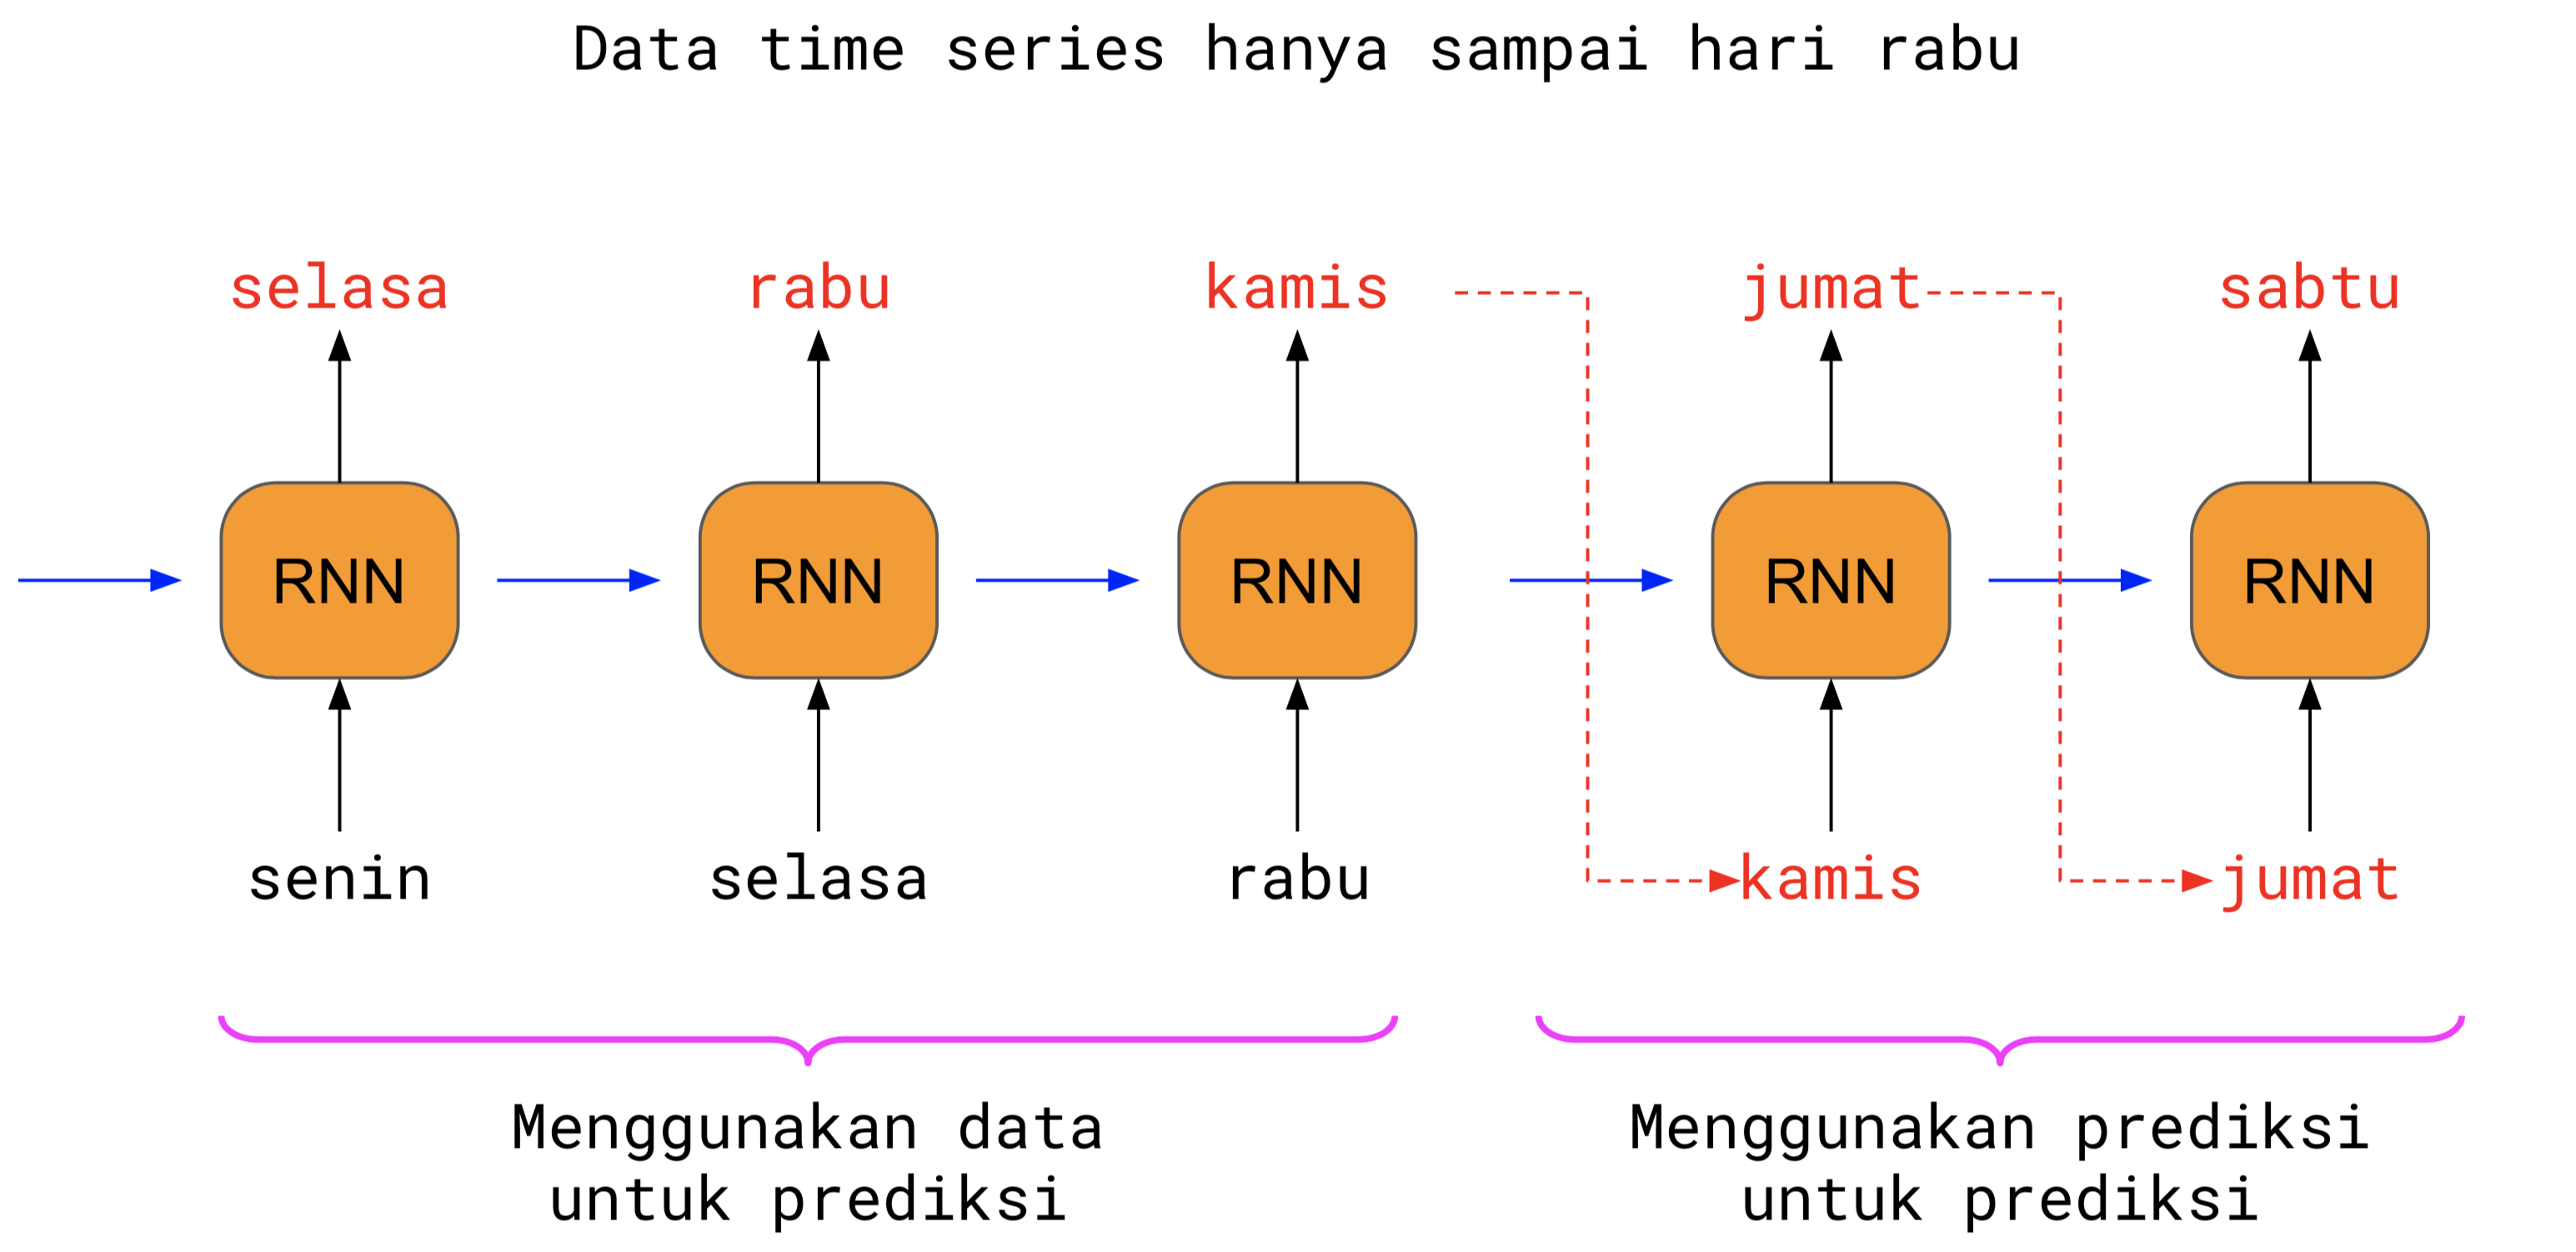

In [40]:
illustration.forecast

In [41]:
from utils import data4pred, pred4pred

In [42]:
train_forecast_set =TimeSeriesDataset(ts_train,"Temp",1)
trainforecastloader = DataLoader(train_forecast_set)
test_forecast_set =TimeSeriesDataset(ts_test,"Temp",1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (2919, 1, 1)
Note: last 0 data excluded

(N, S, F): (729, 1, 1)
Note: last 0 data excluded



# Visualization

Text(0.5, 1.0, 'Test')

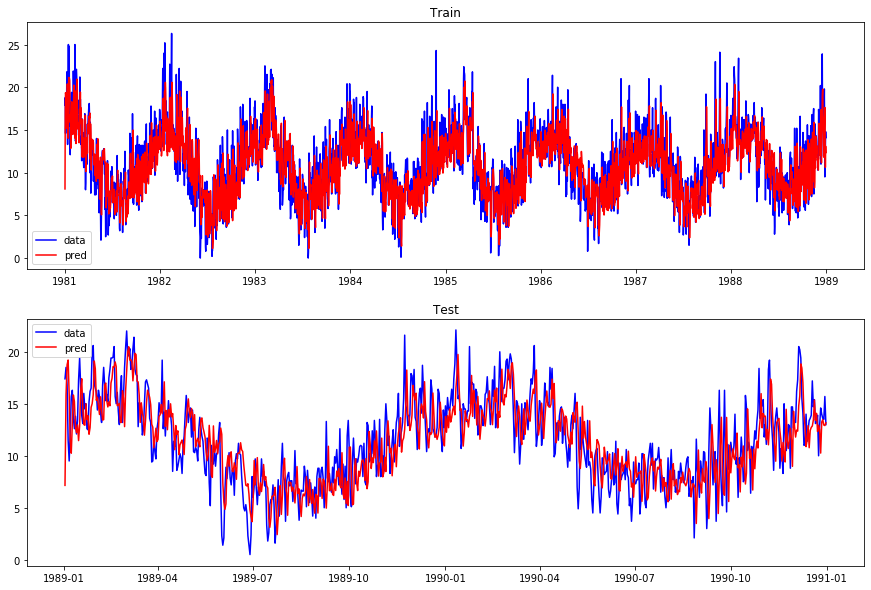

In [43]:
#data 4 pred
plt.figure(figsize=(15,10))

plt.subplot(211)
data4pred(model,train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model,test_forecast_set, testforecastloader, device)
plt.title("Test")

Text(0.5, 1.0, 'Test')

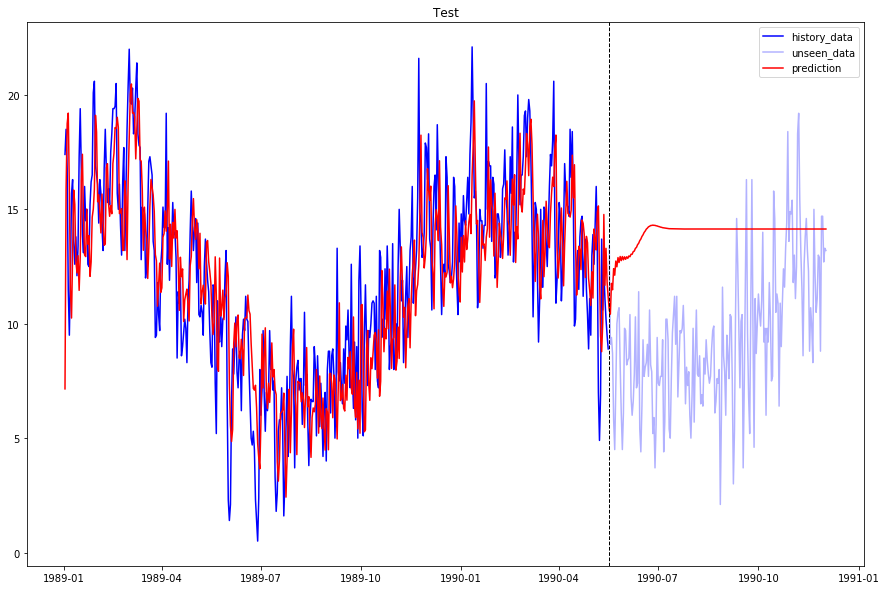

In [44]:
#pred 4 pred
plt.figure(figsize=(15,10))
pred4pred(model,test_forecast_set, testforecastloader, device)
plt.title("Test")